# Localized analysis: band-pass filtering, Hilbert transform

We investigate how low-frequency signals may leak into higher frequencies after band-pass filtering.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import xrft

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors


rad = 2 * np.pi

print_figs = True

## low-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

We answer the issue of cross-contamination: how much energy is left after band-pass filtering ?

In [2]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()

- filter bandwidth = $2\delta_\omega$, that is $\delta_\omega$ is the half bandwidth
- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [3]:
delta = Symbol("delta_omega", positive=True)
T, sigma, U = u_low.p["T"], u_high.p["sigma"], u_low.p["U"]
omega, tau = u_low.omega, u_low.tau

In [4]:
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

This spectrum is integrated next between  $\sigma-\delta_\omega$ and $\sigma+\delta_\omega$.

In [5]:
I_low = u_low.spectrum.integrate((omega, sigma - delta, sigma + delta)) * 2 / 2 / pi
I_low = I_low.simplify()
E_low = lambdify([U, T, sigma, delta], I_low)
I_low

2*U**2*(atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))/pi

In [6]:
I_low.args

(2, 1/pi, U**2, atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))

In [7]:
# manually simplify the sum of arc tangents
# https://fr.wikipedia.org/wiki/Identité_trigonométrique
_x = I_low.args[3].args[0].args[0]
_y = -I_low.args[3].args[1].args[0]
_xy = (_x - _y) / (1 + _x * _y)
_xy = _xy.func(*(factor(term) for term in _xy.args))

# hypothèse T x sigma > 1
I_low = I_low.args[0] * I_low.args[1] * I_low.args[2] * atan(_xy)
E_low = lambdify([U, T, sigma, delta], I_low)
I_low

-2*U**2*atan(2*T*delta_omega/(T**2*delta_omega**2 - T**2*sigma**2 - 1))/pi

The formula above provides the unapproximated energy leaking in the $[\sigma-\delta_\omega, \sigma+\delta_\omega]$ band.

The limits when $\sigma T\gg 1$ (while $\delta_\omega < \sigma$) is given by:

In [8]:
low_proj = lambda U, T, sigma, delta, pi: U**2 * 4 * delta / T / sigma**2 / pi
low_proj(U, T, sigma, delta, pi)

4*U**2*delta_omega/(pi*T*sigma**2)

As a reminder: $T$ is the low-frequency signal decorrelation time scale, 
$\sigma$ the high-frequency signal frequency and $\delta_\omega$ a filtering half bandwidth.

In [9]:
# alternative route: start from approximated spectrum
T, sigma, U = u_low.p["T"], u_high.p["sigma"], u_low.p["U"]
omega = u_low.omega
_E = 2 * U**2 / T / omega**2
_I = _E.integrate((omega, sigma - delta, sigma + delta)) * 2 / 2 / pi
_I.simplify()

-4*U**2*delta_omega/(pi*T*(delta_omega - sigma)*(delta_omega + sigma))

#### Illustration

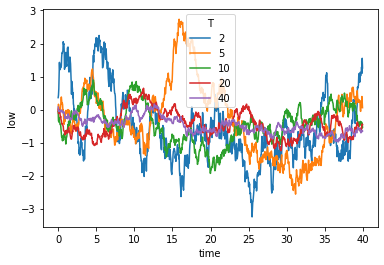

In [10]:
da = u_low.generate_tseries(
    params=dict(T=[2, 5, 10, 20, 40]), time=(1000, 1 / 24), seed=0
).persist()
_ = da.where(da.time < 40).plot.line(x="time")

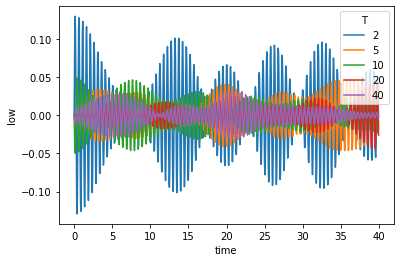

In [11]:
# create filter
_p = u_high.p_values
dt = float(da.time[1] - da.time[0])
f = dict(hbandwidth=1 / _p["T"], sigma=_p["sigma"] / rad)
f["h"], f["t"] = sigp.bpass_filter(
    f["sigma"], f["hbandwidth"], int(50 / dt), dt, "firwin"
)

# filter time series
da_filtered = sigp.filt(da, f["h"])
_ = da_filtered.where(da.time < 40).plot.line(x="time")

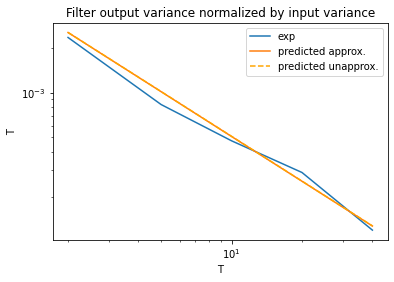

In [12]:
ax = plt.subplot(111)
(da_filtered.var("time") / da.var("time")).plot(ax=ax, label="exp")

# sigma is converted only once to rad/d because of the ratio delta_omega/sigma
# r = 4*f['domega']/(np.pi*da.T*2*np.pi*f['sigma']**2)
r = low_proj(1.0, da["T"], rad * f["sigma"], rad * f["hbandwidth"], np.pi)
r.plot(ax=ax, label="predicted approx.")
rbis = E_low(1.0, da["T"], rad * f["sigma"], rad * f["hbandwidth"])
rbis.plot(ax=ax, label="predicted unapprox.", color="orange", ls="--")

# ax.axhline(1e-3, color='k')
ax.legend()
ax.set_title("Filter output variance normalized by input variance")

ax.set_xscale("log")
ax.set_yscale("log")

**Conclusion**: the variance that leaks out varies as $U^2 \times 4\delta_\omega/(\pi T\sigma^2)$.

It varies linearly with filter bandwidth, inversely with the slow-signal decorrelation time scale and inversely with the square of the high-frequency signal frequency.

## high-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

Parameters of the problem are:
- U = signal amplitude. The signal variance is $U^2/2$
- $\sigma$: signal frequency and band-pass filter central frequency
- $T$ = signal decorrelation time scale (exponential autocorrelation of the enveloppe)
- filter bandwidth = $2\delta_\omega$

In [13]:
I_high = u_high.spectrum.integrate((omega, sigma - delta, sigma + delta)) * 2 / 2 / pi
I_high = I_high.simplify()
E_high = lambdify([U, T, sigma, delta], I_high)
I_high

U**2*(atan(T*(delta_omega - sigma)/2) + atan(T*(delta_omega + sigma)/2) + atan(T*(delta_omega - sigma)*(-T**2*sigma**2 + T**2*(delta_omega - sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))) + atan(T*(delta_omega + sigma)*(-T**2*sigma**2 + T**2*(delta_omega + sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))))/(2*pi)

In [14]:
# normalize parameters
s = Symbol("s", positive=True)
d = Symbol("d", positive=True)
I_high_norm = I_high.subs({sigma: s / T, delta: d / T}).simplify()
E_high_norm = lambdify([U, s, d], I_high_norm)
I_high_norm

U**2*(atan((d - s)*(-s**2 + (d - s)**2 + 3)/(2*(s**2 + 1))) + atan((d + s)*(-s**2 + (d + s)**2 + 3)/(2*(s**2 + 1))) + atan(d/2 - s/2) + atan(d/2 + s/2))/(2*pi)

In [15]:
_delta = np.linspace(0, 2.0, 100)
_s = [1, 10, 20]
ds = xr.Dataset(
    None,
    coords={"delta": (["delta"], _delta), "sigma": (["sigma"], _s)},
)
U = 1.0
ds["E"] = E_high_norm(U, rad * ds.sigma, rad * ds.delta)
ds["E"] = ds["E"].where(ds.delta <= ds.sigma)

Text(0.5, 1.0, 'Fraction of output variance recovered')

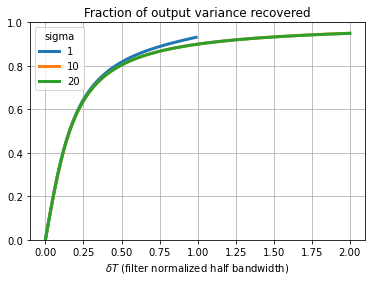

In [16]:
ax = plt.subplot(111)
(ds.E / (U**2 / 2)).plot.line(x="delta", ax=ax, lw=3)
ax.grid()
ax.set_ylim(0, 1)
ax.set_ylabel("")
ax.set_xlabel(r"$\delta T$ (filter normalized half bandwidth)")
ax.set_title("Fraction of output variance recovered")

**Conclusion:** assuming an ideal band-pass filter, 90% of the total variance is recovered if the filter bandwidth is $1/T$ (see `high.ipynb` for values with other autocorrelation shapes). 
Any departure from an ideal filter may require larger bandwidths

A filter should at least be of width $1/T$, but $T$ is partially unknown in practice.
So we'd like to the filter to be wider.
This may however lead to projection of the low frequency signal.

The variance of a sum signal is (assuming $\delta_\omega T_{high} > 1$):

$
\begin{align}
U_{sum}^2 = 
U_{low}^2 \times 4\delta_\omega/(\pi T_{low}\sigma^2)
+
U_{high}^2 /2
\end{align}
$

We'd like the variance of the cross-projection (first term on the right-handside in equation above) to stay below a $\epsilon$ threshold (for example 10\%):

$
\begin{align}
\delta_\omega
&< \sigma \times \epsilon \frac{\pi T_{low}\sigma}{8} \frac{U_{high}^2}{U_{low}^2}
\end{align}
$

Recollecting the lower bound $1/T_{high}$ assumed on $\delta_\omega$, such filtering is only possible if:

$
\begin{align}
\epsilon 
\times (T_{high}\sigma)
\times (T_{low}\sigma) 
>
\frac{8}{\pi} \frac{U_{low}^2}{U_{high}^2}
\end{align}
$

The later ratio can be used to diagnose a critical amplitude ratios, or time scale values

**Illustration**

The amplitude of the low-frequency flow and temporal scales (low-frequency decorrelation, high-frequency nonstationarity) are fixed next.
The amplitude of the high-frequency flow is varied and we monitor the amplitude of filter output as a function of the filter bandwidth.

We ignore any stationary contribution here. 

The goal is to highlight how sensitive the cross-contamination is to filter bandwidth and high to low relative amplitudes.

In [17]:
U_low = 1.0
T_low = 10.0  # d
T_high = 10.0  # d
sigma = 1.0  # cpd
# epsilon = .1 # unitless

_delta = np.linspace(0, sigma, 100)
_u = [0.01, 0.1, 0.5, 1.0]
ds = xr.Dataset(
    None,
    coords={
        "delta": (["delta"], _delta),
        "U_high": (["U_high"], _u),
    },
)

ds["E_high"] = E_high(ds.U_high, T_high, rad * sigma, rad * ds.delta)
ds["E_low"] = E_low(U_low, T_low, rad * sigma, rad * ds.delta)
ds["E"] = ds["E_high"] + ds["E_low"]

Text(0.1, 2e-05, '$1/T_{high}$')

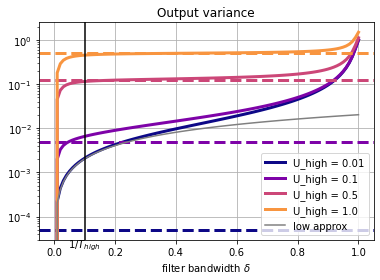

In [18]:
colors = get_cmap_colors(ds.U_high.size)

ax = plt.subplot(111)
for u, c in zip(ds.U_high, colors):
    ds.E.sel(U_high=u).plot.line(
        x="delta", ax=ax, lw=3, color=c, label="U_high = {}".format(float(u))
    )
    ax.axhline(u**2 / 2, color=c, ls="--", lw=3)

I_low_approx = U_low**2 * 4 * ds.delta / (np.pi * T_low * sigma**2) / rad
I_low_approx.plot(ax=ax, color="0.5", label="low approx")

ax.grid()
# ax.set_ylim(0,1)
# ax.set_xlabel('delta T (filter normalized bandwidth)')
ax.set_title("Output variance")
ax.set_xlabel("filter bandwidth $\delta$")
ax.set_ylabel("")
ax.set_yscale("log")
ax.axvline(1 / T_high, color="k")
ax.legend()
ax.text(1 / T_high, 2 * 1e-5, r"$1/T_{high}$", rotation=0, ha="center")

On the figure above:
- cross-contamination has to occur when the variance is larger than that of the high frequency signal (horizontal dashed line).
- no significant cross-contamination occurs for high frequency signal amplitudes larger than $0.5$.
- for smaller amplitudes, cross-contamination ($0.01$ and $0.1$) is observed for filter bandwidth smaller than $1/T_{high}$.
- in the worst case scenario ($U_{high}=0.01$), the output variance follows the low-frequency output variance estimate which means the low-frequency signal dominates no matter what is the value of the filter bandwidth.

Recall, low-frequency signal amplitude is 1.

In [19]:
# compute spectra
ds = ds.assign_coords(omega=("omega", np.arange(1 / 100, 12, 1 / 100)))
ds["spectrum_low"] = u_low.evaluate_spectrum(omega=ds.omega * rad, T=T_low, U=U_low)
ds["spectrum_high"] = u_high.evaluate_spectrum(
    omega=ds.omega * rad, T=T_high, U=ds.U_high, sigma=sigma * rad
)
ds["spectrum"] = ds["spectrum_low"] + ds["spectrum_high"]

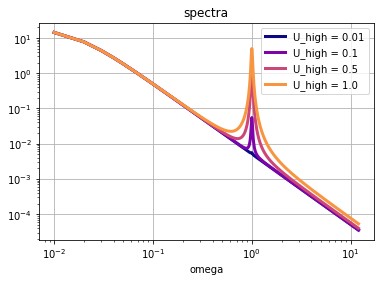

In [20]:
ax = plt.subplot(111)
for u, c in zip(ds.U_high, colors):
    ds.spectrum.sel(U_high=u).plot.line(
        x="omega", ax=ax, lw=3, color=c, label="U_high = {}".format(float(u))
    )
    # ax.axhline(u**2, color=c, ls='--', lw=3)
ax.grid()
ax.set_title("spectra")
# ax.set_xlabel('filter bandwidth $\delta$')
ax.set_ylabel("")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

**final notes**

We have ignored any stationary contribution here. 
Stationary contributions would improve the situation as all the high frequency energy is concentrated in a narrow bandwidth and the high frequency spectrum is expected to exceed the low-frequency one locally.
Selecting a narrow frequency filter will always enable to capture the signal.

- What should we do in defavorable situations: improve SNR with preprocessing (look at other variables, independent estimate of low-frequency variability, PV inversion, assimilation with adequate dynamical models)
- What's going on in the real ocean? How often will it be complicated to extract the high frequency signal because of the low-frequency variability and for what variables?

---

## things remaining to be done, questions

- show impact of a low frequency contribution on the estimate of the lag, better synthesis
- illustrate stationary case? (issue with mean in autocorrelation computation)
- illustrate effect of neighbooring stationary frequencies
- sensitivity to filter kernel length?
- show statistical accuracy of the lag/variance estimate as a function of time window ?
- can the fast decorrelation of the band-passed low frequency enveloppes be leveraged when the high frequency signal exhibit a larger correlation? Can we quantify the decorrelation timescale of the band-passed low frequency enveloppe?